# Final Distribution

In [1]:
from config import PROJECT_ID, INITIAL_TS, SNAPSHOT_TS, \
    CITIZENS_AUDIENCE, ETH_ANALYSIS_DATASET_NAME, ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    CRYPTOPUNKS_AUDIENCE, \
    HACKERS_AUDIENCE, GAS_ANALYSIS_DATASET_NAME, GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    LEADERS_AUDIENCE, ERC20_TOP_DISTRIBUTION_TABLE_NAME, \
    MASTERS_AUDIENCE, ERC721_ANALYSIS_DATASET_NAME, ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    INVESTORS_AUDIENCE, ERC20_ANALYSIS_DATASET_NAME, ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    HEROES_AUDIENCE, GENESIS_AND_ETH2_DATASET_NAME, GENESIS_AND_ETH2_DISTRIBUTION_TABLE_NAME, \
    COSMOS_AUDIENCE, COSMOS_DATASET_NAME, COSMOS_DISTRIBUTION_TABLE_NAME, \
    MANUAL_ADDRESSES_AUDIENCE, MANUAL_ADDRESSES_DATASET_NAME, MANUAL_ADDRESSES_DISTRIBUTION_TABLE_NAME, \
    FINAL_DATASET_NAME, DISTRIBUTION_TABLE_NAME, FINAL_DISTRIBUTION_TABLE_NAME, CONTRACT_ADDRESSES_TABLE, \
    GIFT_PER_ADDRESS_PIVOT_TABLE_NAME
from src.utils_bigquery import create_table, drop_table, get_df
from src.utils_charts import heatmap_from_df


CREATE_CONTRACT_TABLE = False
DROP_TABLES = True
CREATE_TABLES = True

## Set cyberGift for the Audiences
**Total Supply:** 1 PCYB = 1e15 CYB


**1% of Total Supply:** 10 TCYB = 1e13 CYB


Distribution between **audiences**


<table style="text-align: left">
    <thead style="text-align: center">
        <tr>
            <th>Audience</th>
            <th>Share of Total Supply</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> Average Citizens </td>
            <td style="text-align: center"> 35% </td>
        </tr>
        <tr>
            <td style="text-align: left"> Cyberpunks </td>
            <td style="text-align: center"> 2% </td>
        </tr>
        <tr>
            <td style="text-align: left"> Extraordinary Hackers </td>
            <td style="text-align: center"> 7% </td>
        </tr>
        <tr>
            <td style="text-align: left"> Key Opinion Leaders </td>
            <td style="text-align: center"> 2% </td>
        </tr>
        <tr>
            <td style="text-align: left"> Masters of the Great Web </td>
            <td style="text-align: center"> 13% </td>
        </tr>
        <tr>
            <td style="text-align: left"> Passionate Investors </td>
            <td style="text-align: center"> 3% </td>
        </tr>
        <tr>
            <td style="text-align: left"> True Heroes of the Great Web </td>
            <td style="text-align: center"> 5% </td>
        </tr>
    </tbody>
</table>

In [2]:
gift_per_audience = {
    CITIZENS_AUDIENCE : 35e13,
    CRYPTOPUNKS_AUDIENCE: 2e13,
    HACKERS_AUDIENCE: 7e13,
    LEADERS_AUDIENCE: 2e13,
    MASTERS_AUDIENCE: 13e13,
    INVESTORS_AUDIENCE: 3e13,
    HEROES_AUDIENCE: 5e13,
    COSMOS_AUDIENCE: 1e13
}

## Create Contracts Table

In [3]:
query_1 = f'''
    SELECT
        to_address as address
    FROM `bigquery-public-data.crypto_ethereum.traces`
    WHERE block_timestamp >= '{INITIAL_TS}'
      AND block_timestamp <= '{SNAPSHOT_TS}'
      AND trace_type ='create'
      AND status = 1
'''

if CREATE_CONTRACT_TABLE:
    if DROP_TABLES:
        drop_table(table_name=CONTRACT_ADDRESSES_TABLE,
                   dataset_name=FINAL_DATASET_NAME)
    if CREATE_TABLES:
        create_table(query_1=query_1,
                     table_name=CONTRACT_ADDRESSES_TABLE,
                     dataset_name=FINAL_DATASET_NAME)

## Create Distribution Table without Gift Size

In [4]:
query_1 = f'''
    SELECT
        audience,
        segment,
        address,
        grade
    FROM (
        SELECT
            audience,
            segment,
            address,
            grade,
            ROW_NUMBER() OVER (PARTITION BY audience, address ORDER BY grade DESC) AS rank
        FROM (
            SELECT
                '{HEROES_AUDIENCE}' AS audience,
                segment,
                address,
                grade
            FROM `{PROJECT_ID}.{GENESIS_AND_ETH2_DATASET_NAME}.{GENESIS_AND_ETH2_DISTRIBUTION_TABLE_NAME}`
            WHERE grade IS NOT NULL

            UNION ALL

            SELECT
                IF(segment = 'Contract Creator by Factory', '{MASTERS_AUDIENCE}', '{HACKERS_AUDIENCE}') AS audience,
                segment,
                address,
                grade
            FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
            WHERE grade IS NOT NULL

            UNION ALL

            SELECT
                '{CITIZENS_AUDIENCE}' AS audience,
                segment,
                address,
                grade
            FROM `{PROJECT_ID}.{ETH_ANALYSIS_DATASET_NAME}.{ETH_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
            WHERE grade IS NOT NULL

            UNION ALL

            SELECT
                audience,
                segment,
                address,
                grade
            FROM `{PROJECT_ID}.{ERC721_ANALYSIS_DATASET_NAME}.{ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
            WHERE grade IS NOT NULL

            UNION ALL

            SELECT
                audience,
                segment,
                address,
                grade
            FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
            WHERE grade IS NOT NULL

            UNION ALL

            SELECT
                '{LEADERS_AUDIENCE}' AS audience,
                '{LEADERS_AUDIENCE}' AS segment,
                address,
                grade
            FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_TOP_DISTRIBUTION_TABLE_NAME}`
            WHERE grade IS NOT NULL

            UNION ALL

            SELECT
                '{MANUAL_ADDRESSES_AUDIENCE}' AS audience,
                '{MANUAL_ADDRESSES_AUDIENCE}' AS segment,
                address,
                3 AS grade
            FROM `{PROJECT_ID}.{MANUAL_ADDRESSES_DATASET_NAME}.{MANUAL_ADDRESSES_DISTRIBUTION_TABLE_NAME}`
            )
        WHERE address NOT IN (SELECT address FROM `{PROJECT_ID}.{FINAL_DATASET_NAME}.{CONTRACT_ADDRESSES_TABLE}`))
    WHERE rank = 1

    UNION ALL

    SELECT
        '{COSMOS_AUDIENCE}' AS audience,
        'ATOM Balances' AS segment,
        address,
        grade
    FROM `{PROJECT_ID}.{COSMOS_DATASET_NAME}.{COSMOS_DISTRIBUTION_TABLE_NAME}`
    WHERE grade IS NOT NULL
'''

if DROP_TABLES:
    drop_table(table_name=DISTRIBUTION_TABLE_NAME,
               dataset_name=FINAL_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_1,
                 table_name=DISTRIBUTION_TABLE_NAME,
                 dataset_name=FINAL_DATASET_NAME)

Table final:distribution_without_gift_size has been deleted.
Table final:distribution_without_gift_size has been created and filled 6522934 rows.


## Create Gift per Address Pivot Table

In [12]:
query_2 = f'''
    WITH gift_data AS (
        SELECT
            audience,
            [STRUCT(1 AS grade, grade_1 AS number_of_addresses, ROUND(IF(grade_1 > 0, gift_amount_per_audience / grade_1 / number_of_grades, 0), 2) as gift_per_address),
             STRUCT(2 AS grade, grade_2 AS number_of_addresses, ROUND(IF(grade_2 > 0, gift_amount_per_audience / grade_2 / number_of_grades, 0), 2) as gift_per_address),
             STRUCT(3 AS grade, grade_3 AS number_of_addresses, ROUND(IF(grade_3 > 0, gift_amount_per_audience / grade_3 / number_of_grades, 0), 2) as gift_per_address)] as gift_data_by_audience,
            total_addresses AS number_of_addresses_in_audience,
            gift_amount_per_audience
        FROM (
            SELECT
                audience,
                SUM(IF(grade=1, address_count, 0)) AS grade_1,
                SUM(IF(grade=2, address_count, 0)) AS grade_2,
                SUM(IF(grade=3, address_count, 0)) AS grade_3,
                SUM(address_count) AS total_addresses,
                COUNTIF(address_count > 0) AS number_of_grades
            FROM (
                SELECT
                    audience,
                    grade,
                    count(distinct address) as address_count
                FROM `{PROJECT_ID}.{FINAL_DATASET_NAME}.{DISTRIBUTION_TABLE_NAME}`
                WHERE grade IN (1, 2, 3)
                  AND audience != '{MANUAL_ADDRESSES_AUDIENCE}'
                GROUP BY audience, grade)
            GROUP BY audience)
        LEFT JOIN (
            SELECT
                gift.audience as audience,
                gift.amount_per_audience as gift_amount_per_audience
            FROM UNNEST([{''.join(f"STRUCT('{k}' AS audience, {v} AS amount_per_audience), " for k,v in gift_per_audience.items())[:-2]}]) AS gift
            )
        USING (audience))
    SELECT
        audience,
        number_of_addresses_in_audience,
        gift_data_by_audience.number_of_addresses as number_of_addresses,
        gift_data_by_audience.grade as grade,
        gift_data_by_audience.gift_per_address as gift_per_address
    FROM gift_data
    CROSS JOIN UNNEST(gift_data.gift_data_by_audience) AS gift_data_by_audience
'''

if DROP_TABLES:
    drop_table(table_name=GIFT_PER_ADDRESS_PIVOT_TABLE_NAME,
               dataset_name=FINAL_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_2,
                table_name=GIFT_PER_ADDRESS_PIVOT_TABLE_NAME,
                dataset_name=FINAL_DATASET_NAME)

Table final:gift_per_address_pivot has been deleted.
Table final:gift_per_address_pivot has been created and filled 24 rows.


In [13]:
print(query_2)


    WITH gift_data AS (
        SELECT
            audience,
            [STRUCT(1 AS grade, grade_1 AS number_of_addresses, ROUND(IF(grade_1 > 0, gift_amount_per_audience / grade_1 / number_of_grades, 0), 2) as gift_per_address),
             STRUCT(2 AS grade, grade_2 AS number_of_addresses, ROUND(IF(grade_2 > 0, gift_amount_per_audience / grade_2 / number_of_grades, 0), 2) as gift_per_address),
             STRUCT(3 AS grade, grade_3 AS number_of_addresses, ROUND(IF(grade_3 > 0, gift_amount_per_audience / grade_3 / number_of_grades, 0), 2) as gift_per_address)] as gift_data_by_audience,
            total_addresses AS number_of_addresses_in_audience,
            gift_amount_per_audience
        FROM (
            SELECT
                audience,
                SUM(IF(grade=1, address_count, 0)) AS grade_1,
                SUM(IF(grade=2, address_count, 0)) AS grade_2,
                SUM(IF(grade=3, address_count, 0)) AS grade_3,
                SUM(address_count) AS total_addresse

## Create Final Distribution Table

In [14]:
query_3 = f'''
    SELECT
        audience,
        segment,
        address,
        grade,
        gift
    FROM `{PROJECT_ID}.{FINAL_DATASET_NAME}.{DISTRIBUTION_TABLE_NAME}`
    LEFT JOIN (
        SELECT
            audience,
            grade AS grade,
            gift_per_address / 1e6 AS gift
        FROM `{PROJECT_ID}.{FINAL_DATASET_NAME}.{GIFT_PER_ADDRESS_PIVOT_TABLE_NAME}`
        )
    USING (audience, grade)
    WHERE audience != '{MANUAL_ADDRESSES_AUDIENCE}'

    UNION ALL

    SELECT
        '{MANUAL_ADDRESSES_AUDIENCE}' AS audience,
        '{MANUAL_ADDRESSES_AUDIENCE}' AS segment,
        address,
        3 AS grade,
        amount / 1e6 AS gift
    FROM `{PROJECT_ID}.{MANUAL_ADDRESSES_DATASET_NAME}.{MANUAL_ADDRESSES_DISTRIBUTION_TABLE_NAME}`
'''

if DROP_TABLES:
    drop_table(table_name=FINAL_DISTRIBUTION_TABLE_NAME,
               dataset_name=FINAL_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_3,
                 table_name=FINAL_DISTRIBUTION_TABLE_NAME,
                 dataset_name=FINAL_DATASET_NAME)

Table final:final_distribution has been deleted.
Table final:final_distribution has been created and filled 6522935 rows.


## Distribution Heatmap

In [7]:
query_4 = f'''
    SELECT
        ANY_VALUE(audiences) AS audiences,
        count(address) AS address_count
    FROM (
        SELECT
            address,
            ARRAY_AGG(DISTINCT audience) as audiences
        FROM `{PROJECT_ID}.{FINAL_DATASET_NAME}.{FINAL_DISTRIBUTION_TABLE_NAME}`
        WHERE audience NOT IN ('{COSMOS_AUDIENCE}')
        GROUP BY address)
    GROUP BY TO_JSON_STRING(audiences)
'''

final_distribution_df = get_df(query_4)

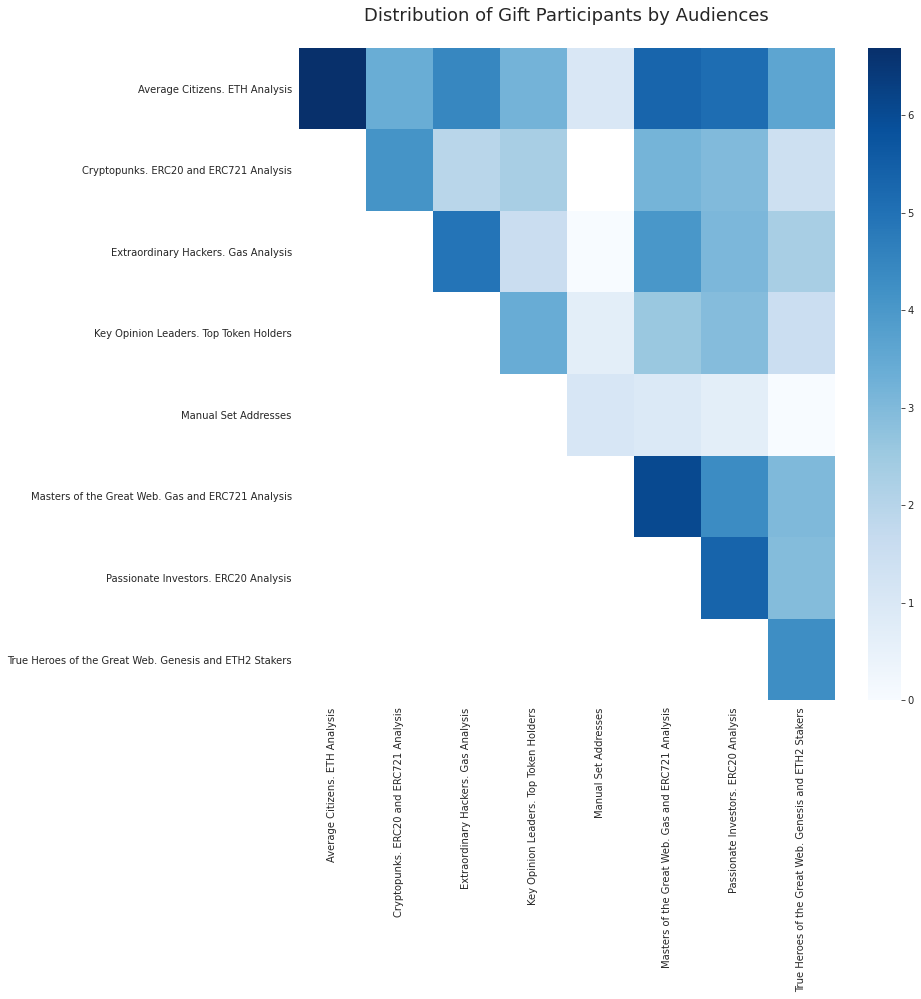

In [8]:
heatmap_from_df(final_distribution_df,
                title='Distribution of Gift Participants by Audiences\n',
                fig_size=12)